# NFL Big Data Bowl 2020 - 1st place solution The Zoo

This notebook aims to reproduce the NFL Big Data Bowl 2020 winner solution described in [1]. The purpose of the competiton was to develop a model to predict how many yards a team will gain on given rushing plays as they happen[2]. The dataset contains game, play, and player-level data. This elegant solution is only based on player-level data. In particular, on relative location and speed features only.

To understand the proposed solution, assume that in a simplified definition, a rushing play consists on:
- A rusher, whose aim is to run forward as far as possible
- 11 defense players who are trying to stop the rusher
- 10 remaining offense players trying to prevent defenders from blocking or tackling the rusher

Based on this simplified version of the game, the authors in [1] came up with the following network structure:

<img src="images/model_structure.png" style="width:680px;height:200px;">


We will go into the details throughout this notebook.

The remainder of this notebook is organized as follows. Section 1 describes and contains the code for data processing and data augmentation. Section 2 provides the model structure. Finally, section 3 draws some conclusions and some possible improvements

## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import utils

In [2]:
train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

First, we divide the dataset into two daframes. The first dataframe (df_players) contains the columns related to the player-level features. Meanwhile, the second dataframe (df_play) is formed by some play-level features which will be useful to perform some transformations on df_players.

In [3]:
def split_play_and_player_cols(df, predicting=False):
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    df['PlayId'] = df['PlayId'].astype(str)
    
    # We must assume here that the first 22 rows correspond to the same player:
    player_cols = [
        'PlayId', # This is the link between them
        'Season',
        'Team',
        'X',
        'Y',
        'S',
        'Dis',
        'Dir',
        'NflId',
        'IsRusher',
    ]

    df_players = df[player_cols]
    
    play_cols = [
        'PlayId',
        'Season',
        'PossessionTeam',
        'HomeTeamAbbr',
        'VisitorTeamAbbr',
        'PlayDirection', 
        'FieldPosition',
        'YardLine',
    ]
    
    if not predicting:
        play_cols.append('Yards')
        
    df_play = df[play_cols].copy()

    ## Fillna in FieldPosition attribute
    #df['FieldPosition'] = df.groupby(['PlayId'], sort=False)['FieldPosition'].apply(lambda x: x.ffill().bfill())
    
    # Get first 
    df_play = df_play.groupby('PlayId').first().reset_index()

    print('rows/plays in df: ', len(df_play))
    assert df_play.PlayId.nunique() == df.PlayId.nunique(), "Play/player split failed?"  # Boom
    
    return df_play, df_players

play_ids = train["PlayId"].unique()

df_play, df_players = split_play_and_player_cols(train)

rows/plays in df:  31007


We have some problems with the enconding of the teams such as BLT and BAL or ARZ and ARI. Let's fix it.

In [4]:
def process_team_abbr(df):

    #These are only problems:
    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in train['PossessionTeam'].unique():
        map_abbr[abb] = abb

    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)

    df['HomePossession'] = df['PossessionTeam'] == df['HomeTeamAbbr']
    
    return

process_team_abbr(df_play)

In [5]:
def process_play_direction(df):
    df['IsPlayLeftToRight'] = df['PlayDirection'].apply(lambda val: True if val.strip() == 'right' else False)
    return

process_play_direction(df_play)

We compute how many yards are left to the end-zone.

In [6]:
def process_yard_til_end_zone(df):
    def convert_to_yardline100(row):
        return (100 - row['YardLine']) if (row['PossessionTeam'] == row['FieldPosition']) else row['YardLine']
    df['Yardline100'] = df.apply(convert_to_yardline100, axis=1)
    return

process_yard_til_end_zone(df_play)

Now, we add the computed features to df_players

In [7]:
df_players = df_players.merge(
    df_play[['PlayId', 'PossessionTeam', 'HomeTeamAbbr', 'PlayDirection', 'Yardline100']], 
    how='left', on='PlayId')

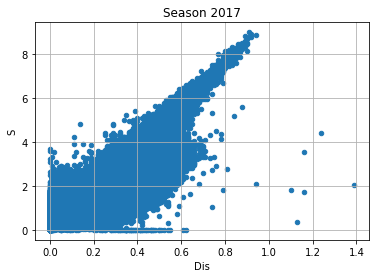

In [8]:
df_players.loc[df_players.Season == 2017].plot.scatter(x='Dis', y='S', title='Season 2017',grid=True)

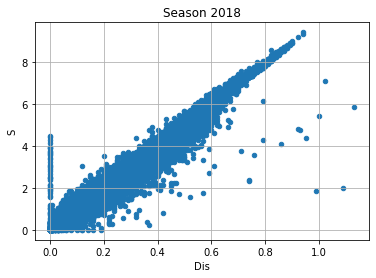

In [9]:
df_players.loc[df_players.Season == 2018].plot.scatter(x='Dis', y='S', title='Season 2018', grid=True)

In 2018 data we can see that S is linearly related to Dis. However, data in 2017 is not very fit. Using a linear regresion to fit the 2018 data, we found that S can be replaced by 10*Dir. This give an improvment in the predictions

In [10]:
X = df_players.loc[df_players.Season == 2018]['Dis']
y = df_players.loc[df_players.Season == 2018]['S']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.137e+07
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:44:18   Log-Likelihood:                 32141.
No. Observations:              247962   AIC:                        -6.428e+04
Df Residuals:                  247960   BIC:                        -6.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.182      0.237      -0.001       0.003
Dis            9.9228      0.003   3372.410      0.000       9.917       9.929
==============================================================================
Omnibus:                   145982.942   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19682710.631
Skew:                          -1.861   Prob(JB):                         0.00
Kurtosis:                      46.488   Cond. No.                         7.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
df_players.loc[df_players.Season == 2017, 'S'] = 10*df_players.loc[df_players.Season == 2017,'Dis']

Now, let's adjusted the data to always be from left to right.

In [12]:
def standarize_direction(df):
    # adjusted the data to always be from left to right
    df['HomePossesion'] = df['PossessionTeam'] == df['HomeTeamAbbr']

    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0

    df['ToLeft'] = df.PlayDirection == "left"
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X']
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y']
    df['Dir_std'] = df.Dir_rad
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)
   
    #Replace Null in Dir_rad
    df.loc[(df.IsOnOffense) & df['Dir_std'].isna(),'Dir_std'] = 0.0
    df.loc[~(df.IsOnOffense) & df['Dir_std'].isna(),'Dir_std'] = np.pi

standarize_direction(df_players)

We adjust only the plays moving to left. To explain the transformation, consider the following images that show two original plays (the purple is the team in offense)

No handles with labels found to put in legend.


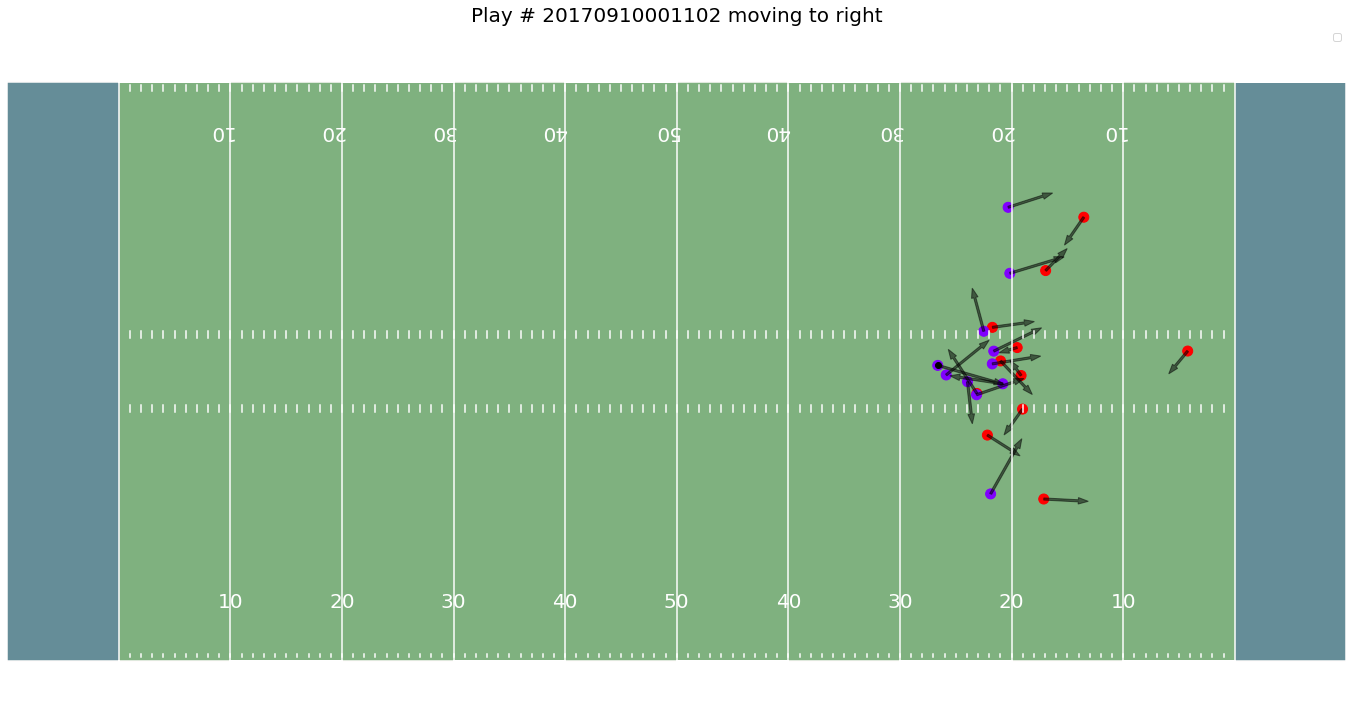

No handles with labels found to put in legend.


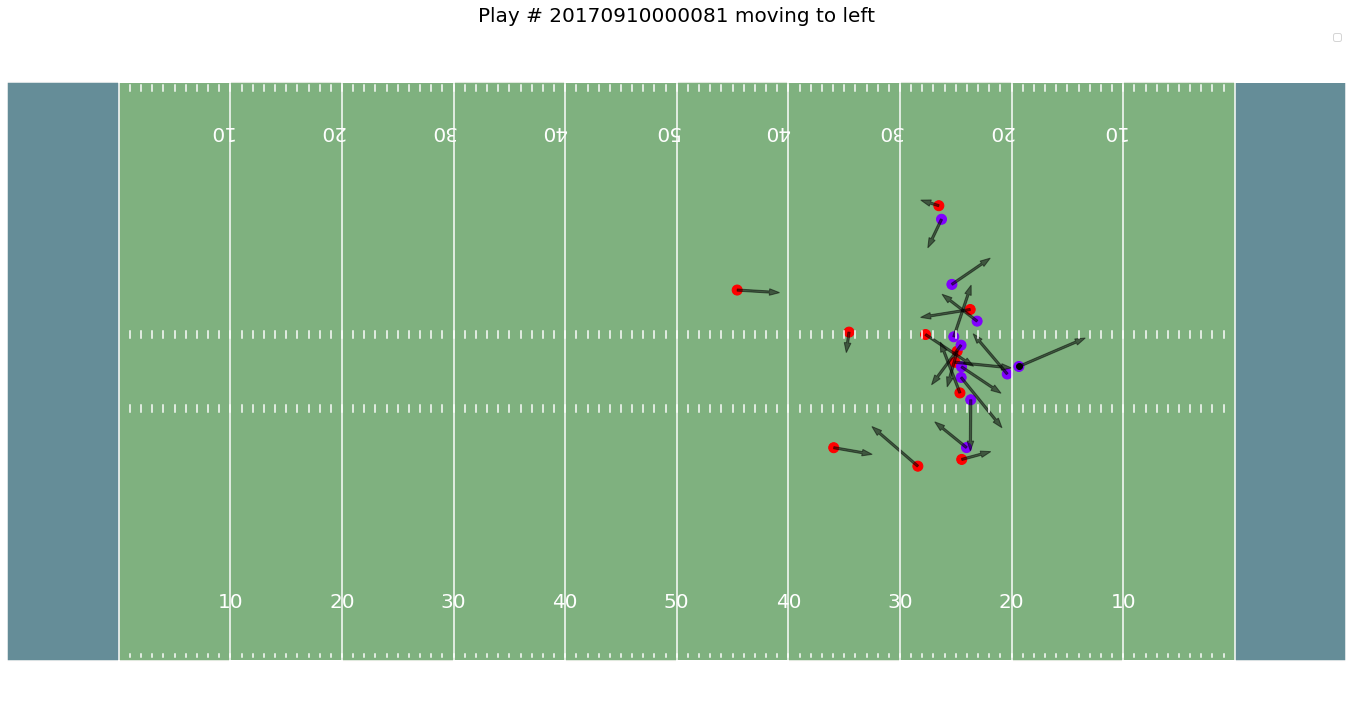

In [13]:
for play_id in ['20170910001102', '20170910000081']: 
    utils.show_play(play_id, df_players)

Now, these are the same plays after the transformation

No handles with labels found to put in legend.


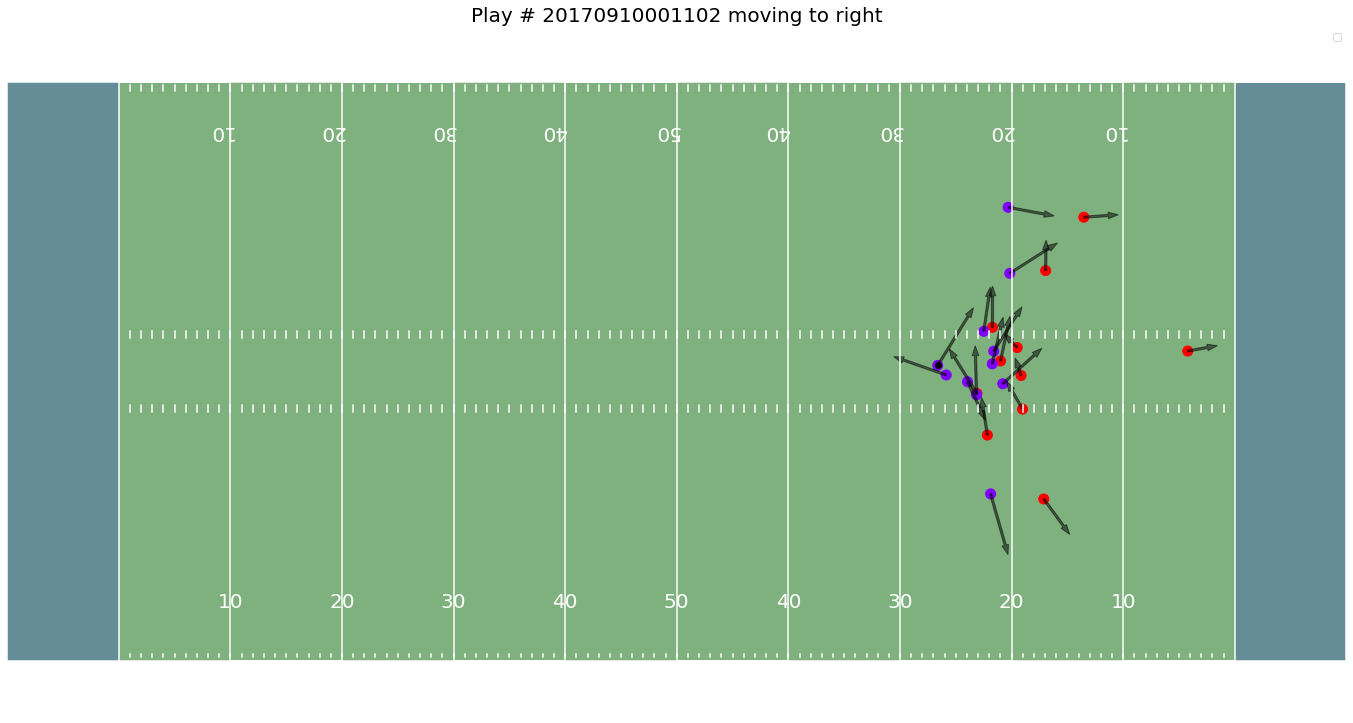

No handles with labels found to put in legend.


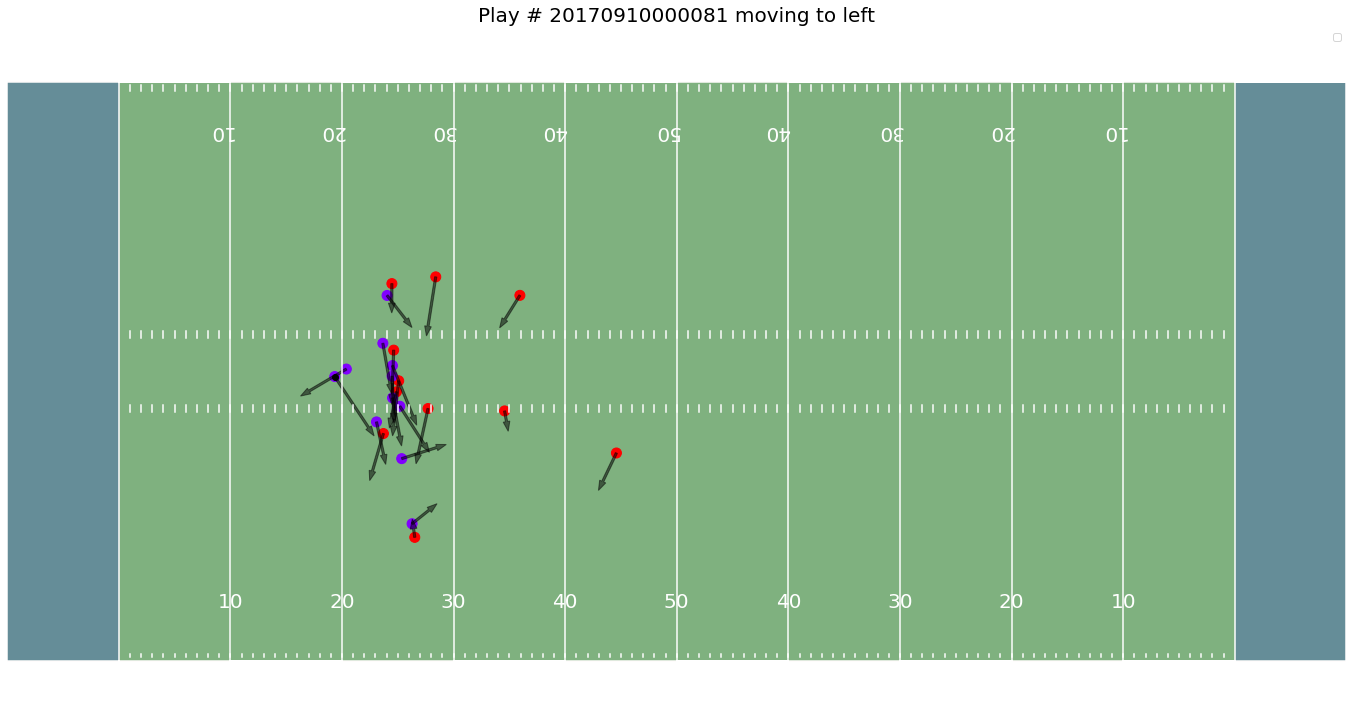

In [14]:
for play_id in ['20170910001102', '20170910000081']: 
    utils.show_play_std(play_id, df_players)

Note that we only modify the plays moving to left. The source code to these plots is taken from [3]

### Data augmentation
For training, we assume that in a mirrored world the runs would have had the same outcomes. We apply 50% augmentation to flip the Y coordinates (and all respective relative features emerging from it). Furthermore, the function process_tracking_data computes the projections on X and Y for the velocity of each player and other features relative to rusher.

In [15]:
def data_augmentation(df, sample_ids):
    df_sample = df.loc[df.PlayId.isin(sample_ids)].copy()
    df_sample['Y_std'] = 160/3  - df_sample['Y_std']
    df_sample['Dir_std'] = df_sample['Dir_std'].apply(lambda x: 2*np.pi - x)
    df_sample['PlayId'] = df_sample['PlayId'].apply(lambda x: x+'_aug')
    return df_sample

def process_tracking_data(df):
    # More feature engineering for all:
    df['Sx'] = df['S']*df['Dir_std'].apply(math.cos)
    df['Sy'] = df['S']*df['Dir_std'].apply(math.sin)
    
    # ball carrier position
    rushers = df[df['IsRusher']].copy()
    rushers.set_index('PlayId', inplace=True, drop=True)
    playId_rusher_map = rushers[['X_std', 'Y_std', 'Sx', 'Sy']].to_dict(orient='index')
    rusher_x = df['PlayId'].apply(lambda val: playId_rusher_map[val]['X_std'])
    rusher_y = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Y_std'])
    rusher_Sx = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Sx'])
    rusher_Sy = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Sy'])
    
    # Calculate differences between the rusher and the players:
    df['player_minus_rusher_x'] = rusher_x - df['X_std']
    df['player_minus_rusher_y'] = rusher_y - df['Y_std']

    # Velocity parallel to direction of rusher:
    df['player_minus_rusher_Sx'] = rusher_Sx - df['Sx']
    df['player_minus_rusher_Sy'] = rusher_Sy - df['Sy']

    return

sample_ids = np.random.choice(df_play.PlayId.unique(), int(0.5*len(df_play.PlayId.unique())))

df_players_aug = data_augmentation(df_players, sample_ids)
df_players = pd.concat([df_players, df_players_aug])
df_players.reset_index()

df_play_aug = df_play.loc[df_play.PlayId.isin(sample_ids)].copy()
df_play_aug['PlayId'] = df_play_aug['PlayId'].apply(lambda x: x+'_aug')
df_play = pd.concat([df_play, df_play_aug])
df_play.reset_index()

# This is necessary to maintain the order when in the next cell we use groupby
df_players.sort_values(by=['PlayId'],inplace=True)
df_play.sort_values(by=['PlayId'],inplace=True)

process_tracking_data(df_players)

In [16]:
tracking_level_features = [
    'PlayId',
    'IsOnOffense',
    'X_std',
    'Y_std',
    'Sx',
    'Sy',
    'player_minus_rusher_x',
    'player_minus_rusher_y',
    'player_minus_rusher_Sx',
    'player_minus_rusher_Sy',
    'IsRusher'
]

df_all_feats = df_players[tracking_level_features]

print('Any null values: ', df_all_feats.isnull().sum().sum())

Any null values:  0


Finally, we create the train tensor to feed the convolutional network. The following image depicts the structure of the input tensor:

<img src="images/input.png" style="width:350px;height:160px;">

Note that the idea is to reshape the data of a play into a tensor of defense vs offense, using features as channels to apply 2d operations (The figure does not follow the convention on ConvNet, and the channels are in the z-axis). There are 5 vector features which were important (so 10 numeric features if you count projections on X and Y axis). The vectors are relative locations and speeds, so to derive them we used only ‘X’, ‘Y’, ‘S’ and ‘Dir’ variables from data.

In [17]:
%%time 

grouped = df_all_feats.groupby('PlayId')
train_x = np.zeros([len(grouped.size()),11,10,10])
i = 0
play_ids = df_play.PlayId.values
for name, group in grouped:
    if name!=play_ids[i]:
        print("Error")

    [[rusher_x, rusher_y, rusher_Sx, rusher_Sy]] = group.loc[group.IsRusher==1,['X_std', 'Y_std','Sx','Sy']].values

    offense_ids = group[group.IsOnOffense & ~group.IsRusher].index
    defense_ids = group[~group.IsOnOffense].index

    for j, defense_id in enumerate(defense_ids):
        [def_x, def_y, def_Sx, def_Sy] = group.loc[defense_id,['X_std', 'Y_std','Sx','Sy']].values
        [def_rusher_x, def_rusher_y] = group.loc[defense_id,['player_minus_rusher_x', 'player_minus_rusher_y']].values
        [def_rusher_Sx, def_rusher_Sy] =  group.loc[defense_id,['player_minus_rusher_Sx', 'player_minus_rusher_Sy']].values
        
        train_x[i,j,:,:4] = group.loc[offense_ids,['Sx','Sy','X_std', 'Y_std']].values - np.array([def_Sx, def_Sy, def_x,def_y])
        train_x[i,j,:,-6:] = [def_rusher_Sx, def_rusher_Sy, def_rusher_x, def_rusher_y, def_Sx, def_Sy]
    
    i+=1

np.save('data/train_x_v4(augmented-50).npy', train_x)

CPU times: user 17min 31s, sys: 2.37 s, total: 17min 33s
Wall time: 17min 33s


Additionally, for training we clip the target to -30 and 50. 

In [18]:
# Transform Y into indexed-classes:
train_y = df_play[['PlayId', 'Yards']].copy()

train_y['YardIndex'] = train_y['Yards'].apply(lambda val: val + 99)

min_idx_y = 71
max_idx_y = 150

train_y['YardIndexClipped'] = train_y['YardIndex'].apply(
    lambda val: min_idx_y if val < min_idx_y else max_idx_y if val > max_idx_y else val)

print('max yardIndex: ', train_y.YardIndex.max())
print('max yardIndexClipped: ', train_y.YardIndexClipped.max())
print('min yardIndex: ', train_y.YardIndex.min())
print('min yardIndexClipped: ', train_y.YardIndexClipped.min())

train_y.to_pickle('data/train_y_v4.pkl')

max yardIndex:  198
max yardIndexClipped:  150
min yardIndex:  84
min yardIndexClipped:  84


In [19]:
df_season = df_play[['PlayId', 'Season']].copy()
df_season.to_pickle('data/df_season_v4.pkl')

## Train ConvNet

In [20]:
train_x = np.load('data/train_x_v4(augmented-100).npy') 
train_y = pd.read_pickle('data/train_y_v4.pkl') 
df_season = pd.read_pickle('data/df_season_v4.pkl')

#num_classes_y = 199
min_idx_y = 71
max_idx_y = 150
num_classes_y = max_idx_y - min_idx_y + 1

In [21]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import (
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AvgPool1D, AvgPool2D, Reshape,
    Input, Activation, BatchNormalization, Dense, Add, Lambda, Dropout, LayerNormalization)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def crps(y_true, y_pred):
    loss = K.mean(K.sum((K.cumsum(y_pred, axis = 1) - K.cumsum(y_true, axis=1))**2, axis=1))/199
    return loss

Let's define the newtork arquitecture. The simplified NN structure looks like this:

<img src="images/model_structure.png" style="width:680px;height:200px;">

"So the first block of convolutions learns to work with defense-offense pairs of players, using geometric features relative to rusher. The combination of multiple layers and activations before pooling was important to capture the trends properly. The second block of convolutions learns the necessary information per defense player before the aggregation. And the third block simply consists of dense layers and the usual things around them. 3 out of 5 input vectors do not depend on the offense player, hence they are constant across “off” dimension of the tensor." [1]

In [22]:
def get_conv_net(num_classes_y):
    #_, x, y, z = train_x.shape
    inputdense_players = Input(shape=(11,10,10), name = "playersfeatures_input")
    
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
    X = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    
    # The second block of convolutions learns the necessary information per defense player before the aggregation.
    # For this reason the pool_size should be (1, 10). If you want to learn per off player the pool_size must be 
    # (11, 1)
    Xmax = MaxPooling2D(pool_size=(1,10))(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool2D(pool_size=(1,10))(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,2))(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(160, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    
    Xmax = MaxPooling1D(pool_size=11)(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool1D(pool_size=11)(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,1))(X)
    
    X = Dense(96, activation="relu")(X)
    X = BatchNormalization()(X)

    X = Dense(256, activation="relu")(X)
    X = LayerNormalization()(X)
    X = Dropout(0.3)(X)

    outsoft = Dense(num_classes_y, activation='softmax', name = "output")(X)

    model = Model(inputs = [inputdense_players], outputs = outsoft)
    return model

In [23]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_valid, y_valid = self.data[0], self.data[1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        logs['val_CRPS'] = val_s
        
        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [24]:
%%time 

models = []
kf = KFold(n_splits=8, shuffle=True)
score = []

for i, (tdx, vdx) in enumerate(kf.split(train_x, train_y)):
    print(f'Fold : {i}')
    X_train, X_val = train_x[tdx], train_x[vdx],
    y_train, y_val = train_y.iloc[tdx]['YardIndexClipped'].values, train_y.iloc[vdx]['YardIndexClipped'].values
    season_val = df_season.iloc[vdx]['Season'].values

    y_train_values = np.zeros((len(y_train), num_classes_y), np.int32)
    for irow, row in enumerate(y_train):
        y_train_values[(irow, row - min_idx_y)] = 1
        
    y_val_values = np.zeros((len(y_val), num_classes_y), np.int32)
    for irow, row in enumerate(y_val - min_idx_y):
        y_val_values[(irow, row)] = 1

    val_idx = np.where(season_val!=2017)
    
    X_val = X_val[val_idx]
    y_val_values = y_val_values[val_idx]

    y_train_values = y_train_values.astype('float32')
    y_val_values = y_val_values.astype('float32')
    
    model = get_conv_net(num_classes_y)

    es = EarlyStopping(monitor='val_CRPS',
                        mode='min',
                        restore_best_weights=True,
                        verbose=0,
                        patience=10)
    
    es.set_model(model)
    metric = Metric(model, [es], [X_val, y_val_values])

    lr_i = 1e-3
    lr_f = 5e-4
    n_epochs = 50 

    decay = (1-lr_f/lr_i)/((lr_f/lr_i)* n_epochs - 1)  #Time-based decay formula
    alpha = (lr_i*(1+decay))
    
    opt = Adam(learning_rate=2e-3, decay=0.01)
    model.compile(loss=crps,
                  optimizer=opt)
    
    model.fit(X_train,
              y_train_values, 
              epochs=n_epochs,
              batch_size=64,
              verbose=1,
              callbacks=[metric],
              validation_data=(X_val, y_val_values))

    val_crps_score = min(model.history.history['val_CRPS'])
    print("Val loss: {}".format(val_crps_score))
    
    score.append(val_crps_score)

    models.append(model)
    
print(np.mean(score))

Fold : 0
Train on 54262 samples, validate on 4794 samples
Epoch 1/50
54262/54262 [==============================] - 28s 519us/sample - loss: 0.0143 - val_loss: 0.0134
Epoch 2/50
54262/54262 [==============================] - 25s 466us/sample - loss: 0.0130 - val_loss: 0.0133
Epoch 3/50
54262/54262 [==============================] - 25s 468us/sample - loss: 0.0127 - val_loss: 0.0129
Epoch 4/50
54262/54262 [==============================] - 25s 469us/sample - loss: 0.0126 - val_loss: 0.0129
Epoch 5/50
54262/54262 [==============================] - 25s 460us/sample - loss: 0.0125 - val_loss: 0.0129
Epoch 6/50
54262/54262 [==============================] - 25s 468us/sample - loss: 0.0124 - val_loss: 0.0128
Epoch 7/50
54262/54262 [==============================] - 27s 501us/sample - loss: 0.0123 - val_loss: 0.0127
Epoch 8/50
54262/54262 [==============================] - 25s 469us/sample - loss: 0.0123 - val_loss: 0.0128
Epoch 9/50
54262/54262 [==============================] - 26s 474us/sa

54262/54262 [==============================] - 26s 478us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 32/50
54262/54262 [==============================] - 26s 474us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 33/50
54262/54262 [==============================] - 26s 471us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 34/50
54262/54262 [==============================] - 26s 481us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 35/50
54262/54262 [==============================] - 25s 467us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 36/50
54262/54262 [==============================] - 26s 487us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 37/50
54262/54262 [==============================] - 24s 450us/sample - loss: 0.0119 - val_loss: 0.0121
Val loss: 0.01205869920860595
Fold : 2
Train on 54262 samples, validate on 4736 samples
Epoch 1/50
54262/54262 [==============================] - 26s 470us/sample - loss: 0.0144 - val_loss: 0.0135
Epoch 2/50
54262/54262 [=====================

54262/54262 [==============================] - 25s 454us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 38/50
54262/54262 [==============================] - 25s 457us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 39/50
54262/54262 [==============================] - 25s 458us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 40/50
54262/54262 [==============================] - 25s 463us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 41/50
54262/54262 [==============================] - 25s 457us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 42/50
54262/54262 [==============================] - 25s 457us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 43/50
54262/54262 [==============================] - 25s 467us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 44/50
54262/54262 [==============================] - 25s 454us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 45/50
54262/54262 [==============================] - 25s 460us/sample - loss: 0.0118 - val_loss: 0.0126
Epoch 46/50
54262/5426

54262/54262 [==============================] - 25s 452us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 23/50
54262/54262 [==============================] - 24s 451us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 24/50
54262/54262 [==============================] - 25s 452us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 25/50
54262/54262 [==============================] - 25s 452us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 26/50
54262/54262 [==============================] - 25s 454us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 27/50
54262/54262 [==============================] - 25s 453us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 28/50
54262/54262 [==============================] - 25s 454us/sample - loss: 0.0120 - val_loss: 0.0125
Epoch 29/50
54262/54262 [==============================] - 25s 453us/sample - loss: 0.0119 - val_loss: 0.0125
Epoch 30/50
54262/54262 [==============================] - 25s 452us/sample - loss: 0.0119 - val_loss: 0.0125
Epoch 31/50
54262/5426

54263/54263 [==============================] - 26s 481us/sample - loss: 0.0119 - val_loss: 0.0127
Epoch 22/50
54263/54263 [==============================] - 25s 461us/sample - loss: 0.0119 - val_loss: 0.0127
Epoch 23/50
54263/54263 [==============================] - 25s 463us/sample - loss: 0.0119 - val_loss: 0.0127
Epoch 24/50
54263/54263 [==============================] - 25s 463us/sample - loss: 0.0119 - val_loss: 0.0127
Val loss: 0.012678240425123317
0.012554219736018057
CPU times: user 8h 58min 22s, sys: 5h 27min 12s, total: 14h 25min 34s
Wall time: 2h 4min 43s


In [25]:
print("The mean validation loss is {}".format(np.mean(score)))

The mean validation loss is 0.012554219736018057


## Conclusions

With this elegant solution, The ZOO won the NFL Big Data Bowl 2020 (Kaggle competition). We submitted this code in kaggle and the score obtained was 0.012445 (16th) [4]. A possible reason for the difference between our score and the winning score (0.011658) is that we do not implement TTA in our predictions. Moreover, the number of trainable parameters in our network structure differs (145,584) from the number that they report in [1] (145,329).

For further improvements, I would suggest trying to add features related to pitch control which was the VIP hint of the competition [5].

[1] https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119400

[2] https://www.kaggle.com/c/nfl-big-data-bowl-2020/overview

[3] https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python

[4] https://www.kaggle.com/jccampos/nfl-2020-winner-solution-the-zoo

[5] http://www.lukebornn.com/papers/fernandez_ssac_2018.pdf